In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-09-16 14:40:01.334800: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-16 14:40:01.387716: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-16 14:40:01.388942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 14:40:02.356770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillageCombined1000-2 - Copy/Train/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 11814 files belonging to 13 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Black_mold',
 'Tomato__Gray_spot',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__powdery_mildew',
 'Tomato_healthy']

In [5]:
len(dataset)

370

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, test_split=0.0, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
def preprocess_data(image, label):
    image = resize_and_rescale(image)
    image = data_augmentation(image)
    label = tf.one_hot(label, depth=13)  # Convert label to one-hot encoded format
    return image, label

train_ds = train_ds.map(preprocess_data)
val_ds = val_ds.map(preprocess_data)
test_ds = test_ds.map(preprocess_data)


In [13]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

In [14]:
len(pre_trained_model.layers)

fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model.layers[:fine_tune_at]:
  layer.trainable = False

In [15]:
import tensorflow as tf

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Reshape((1, 1, 512))(x)
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(13, activation='softmax')(x)





In [16]:
model = tf.keras.Model(pre_trained_model.input, x)


In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [18]:
vgg_classifier = model.fit(train_ds,
epochs = 20,
validation_data=val_ds,
batch_size = BATCH_SIZE,
verbose = 1)

Epoch 1/20
333/333 [==============================] - 800s 2s/step - loss: 2.3972 - acc: 0.1442 - val_loss: 2.0774 - val_acc: 0.2021
Epoch 2/20
333/333 [==============================] - 794s 2s/step - loss: 1.9179 - acc: 0.2770 - val_loss: 1.6363 - val_acc: 0.4136
Epoch 3/20
333/333 [==============================] - 795s 2s/step - loss: 1.4571 - acc: 0.4698 - val_loss: 1.3493 - val_acc: 0.4637
Epoch 4/20
333/333 [==============================] - 796s 2s/step - loss: 1.1121 - acc: 0.5941 - val_loss: 0.9572 - val_acc: 0.6598
Epoch 5/20
333/333 [==============================] - 831s 2s/step - loss: 0.8962 - acc: 0.6788 - val_loss: 1.2088 - val_acc: 0.5889
Epoch 6/20
333/333 [==============================] - 795s 2s/step - loss: 0.7378 - acc: 0.7378 - val_loss: 0.5527 - val_acc: 0.7979
Epoch 7/20
333/333 [==============================] - 793s 2s/step - loss: 0.6276 - acc: 0.7869 - val_loss: 0.7278 - val_acc: 0.7427
Epoch 8/20
333/333 [==============================] - 794s 2s/step - 

In [19]:
model.save("PlantVillageCombined1000-2 - Copy/VGG16_fine_tuned_10/")

INFO:tensorflow:Assets written to: PlantVillageCombined1000-2 - Copy/VGG16_fine_tuned_10/assets


INFO:tensorflow:Assets written to: PlantVillageCombined1000-2 - Copy/VGG16_fine_tuned_10/assets


In [20]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillageCombined1000-2 - Copy/Test/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 1404 files belonging to 13 classes.


In [21]:
test_ds = test_ds.map(preprocess_data)

In [22]:
# model.save("C:\\Users\\USER\\Desktop\\model")

In [23]:
scores = model.evaluate(test_ds)

44/44 [==============================] - 54s 1s/step - loss: 0.2789 - acc: 0.9046


In [24]:
vgg_classifier.history

{'loss': [2.3971643447875977,
  1.9178829193115234,
  1.4570947885513306,
  1.112058162689209,
  0.8962197303771973,
  0.7378003597259521,
  0.627588152885437,
  0.5701292157173157,
  0.48740991950035095,
  0.43531641364097595,
  0.3969159722328186,
  0.3519574999809265,
  0.31003043055534363,
  0.3104398250579834,
  0.26187020540237427,
  0.2561715245246887,
  0.24184204638004303,
  0.21310870349407196,
  0.2113470435142517,
  0.19906872510910034],
 'acc': [0.1442144811153412,
  0.27695202827453613,
  0.4698024392127991,
  0.5940733551979065,
  0.6788334846496582,
  0.7378175258636475,
  0.7869238257408142,
  0.805456280708313,
  0.8308560848236084,
  0.8515521883964539,
  0.86961430311203,
  0.8826904892921448,
  0.8961430191993713,
  0.8946378231048584,
  0.9097836017608643,
  0.9119473099708557,
  0.9178739190101624,
  0.928504228591919,
  0.9289746284484863,
  0.931138277053833],
 'val_loss': [2.0773861408233643,
  1.6362806558609009,
  1.3493331670761108,
  0.9571858644485474,
  

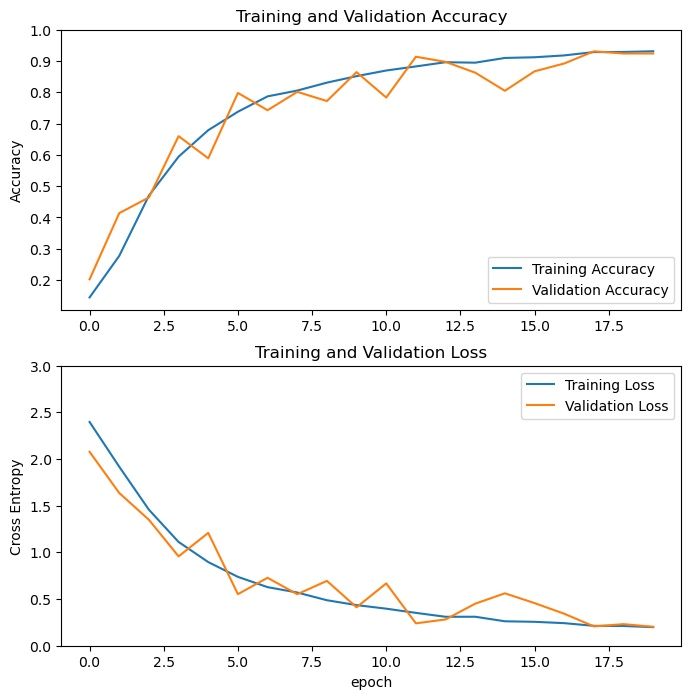

In [25]:
acc = vgg_classifier.history['acc']
val_acc = vgg_classifier.history['val_acc']

loss = vgg_classifier.history['loss']
val_loss = vgg_classifier.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()